# Soil Organic Carbon Stock and Flux estimates for Agricultural Land Uses
*Input to GST AFOLU, Nationally Determined Contributions, and National Adaptation Planning*  

PI: Alyssa Whitcraft  
Team: Kamal Narra, Ritvik Sahajpal  

Estimates of Soil Organic Carbon (SOC) stocks and fluxes are an important yet poorly constrained component of the global climate system. Accurate quantification and error budgeting of SOC stocks and fluxes is needed to study and understand the effects of human activities on the carbon-climate system. These measurements help policymakers assess progress in meeting high-level policy goals, such as National Determined Contributions (NDCs) as well as providing important input to the Global Stocktake of C-emissions and sequestration in Agriculture, Forestry and Other Land Uses (AFOLU) as linked to the Paris Accords and Glasgow Agreement. Further, this information is critical in the development of realistic and scientifically guided national adaptation plans.  

To better inform these stakeholders and priority applications, we will utilize Earth observation (EO) data, machine learning approaches, and existing soil samples to create a global digital SOC stock and flux data product that will provide gridded data at 0.05-degree resolution on SOC stocks, pH, Cation Exchange Capacity (CEC) and fluxes in the form of soil heterotrophic respiration. Soil pH and CEC are key indicators of soil fertility and its ability to sequester soil carbon, an important part of utilizing agriculture to mitigate climate change. SOC stocks and fluxes are needed to compute carbon budgets over agricultural lands. These products can be updated by stakeholders as newer soil samples and EO data become available.

Our approach has the following highlights that results in both the global 0.05-degree products as well as Jupyter notebooks that will allow for flexible, multiscalar, reproducible implementation by stakeholders in their own countries:  
1. We use OpenCube architectures to access EO-based covariates as input to the modeling process.  
2. All the inputs are from publicly available sources.  
3. We provide robust methods to ingest new data inputs as they become available.  
4. We focus on the explainability of model outcomes by producing graphics illustrating the key drivers behind model outputs.    
5. We quantify the accuracy of the product by providing probabilistic estimates for each of the outputs.  

## Load Python Libraries
We use several python libraries in this project. These include standard geospatial processing libraries like rasterio, geopandas and odc_gee. We use scikit-learn for implementing the machine-learning model and pyspatialml library for applying this model to raster inputs.


In [43]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import rasterio as rio
from rasterio.warp import reproject, Resampling, calculate_default_transform

import xarray as xr
import pandas as pd
import geopandas as gpd
import rioxarray as rxr
import earthpy.plot as ep

import pyspatialml
from pyspatialml import Raster
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from odc_gee.earthengine import Datacube

## Training Data

To training ML models to produce global maps of SOC, pH, CEC and SHR, we need training datasets for each of them. We use the following sources:
1. Soil Organic Carbon (SOC):
    - Column with data: `orgc_val_1`
    - https://data.isric.org/geonetwork/srv/api/records/2b643ef9-4bee-44d4-b50d-5020c9133b8b
2. Cation Exchange Capacity (CEC): 
    - Column with data: `cecph7_v_1`
    - https://data.isric.org/geonetwork/srv/api/records/3ed0d2a2-8822-421b-8e89-a7f3bb8a973a
3. pH:
    - Column with data: `phaq_val_1`
    - https://data.isric.org/geonetwork/srv/api/records/44e9cac5-2cb7-41c3-9fbc-0bc8b716e993
4. Soil Heterotropic Respiration (SHR): 
    - Column with data: `Rs_annual`
    - https://github.com/bpbond/srdb

The first three are available as shapefiles, and SHR is available as a CSV file (srdb-data.csv). They are stored in the `inputs/training_data` folder.

These datasets can be readily updated by adding information about the variable of interest and the location (latitude and longitude) from which data was collected.

## Input Data (EO Covariates)
These are available in the `inputs/downloads` folder

**Climatologies at high resolution for the Earth land surface areas**  
*Download URL*: https://chelsa-climate.org/downloads/  
XX ranges from 01 to 12, representing the months January, February ... December  
1. *CHELSA_pet_penman_XX_1981-2010_V.2.1_5km.tif*: monthly potential evaporation; calculated with the Penman-Monteith equation  
2. *CHELSA_pr_XX_1981-2010_V.2.1_5km.tif*: Precipitation amount for each month  
3. *CHELSA_rsds_1981-2010_XX_V.2.1_5km.tif*: Average monthly surface downwelling shortwave flux in air over 1 year  
4. *CHELSA_sfcWind_XX_1981-2010_V.2.1_5km.tif*: Monthly near-surface wind speed  
5. *CHELSA_tas_XX_1981-2010_V.2.1_5km.tif*: Average air temperature at 2 metres from hourly ERA5 data for each month  
6. *CHELSA_tasmax_XX_1981-2010_V.2.1_5km.tif*: Maximum air temperature at 2 metres from hourly ERA5 data for each month  
7. *CHELSA_tasmin_XX_1981-2010_V.2.1_5km.tif*: Minimum air temperature at 2 metres from hourly ERA5 data for each month  
8. *CHELSA_vpd_XX_1981-2010_V.2.1_5km.tif*: Vapor pressure deficit for each month  

**Global Gridded Thickness of Soil, Regolith, and Sedimentary Deposit Layers**  
*Download URL*: https://daac.ornl.gov/SOILS/guides/Global_Soil_Regolith_Sediment.html  
1. *hill-slope_valley-bottom_5km.tif*: A grid of the fraction of area within each grid cell composed of hillslopes versus valley bottoms. In most areas, this grid is very close to the value 1.0 because hillslopes occupy the vast majority of area in most landscapes  
2. *average_soil_and_sedimentary-deposit_thickness_5km.tif*: A grid that averages soil and sedimentary deposit thicknesses in meters for users who want a single thickness value that averages across upland hillslopes and valley bottoms  
3. *upland_hill-slope_regolith_thickness_5km.tif*: upland regolith (soil plus intact regolith) thickness in meters  
4. *upland_hill-slope_soil_thickness_5km.tif*: average upland hillslope soil thickness in meters  
5. *upland_valley-bottom_and_lowland_sedimentary_deposit_thickness_5km.tif*: A grid of average upland valley bottom and lowland sedimentary deposit thickness in meters  
6. *land_cover_mask_5km.tif*: Landcover mask that classifies each grid cell as predominantly ocean, upland, lowland, lake, or perennial ice using  values from 0 to 4, respectively  

**Global Cloud Cover**  
*Download URL*: https://www.earthenv.org/cloud  
1. *MODCF_intraannualSD_5km.tif*: Intra-annual mean of cloud observations derived from 15 years of twice-daily remote sensing  
2. *MODCF_meanannual_5km.tif*: Annual mean of cloud observations derived from 15 years of twice-daily remote sensing  

**Harmonizing inputs**  
We have two types of inputs in this project. The first type of inputs are listed above and include raster files of environmental covariates like precipitation, temperature etc. The second type of inputs are the point data that provide estimates of the four data products for which we will produce global maps: SOC stocks, pH, Cation Exchange Capacity (CEC) and fluxes in the form of soil heterotrophic respiration.

To run a machine-learning model using the first set of inputs, we need to ensure that all of them are geospatially harmonized i.e. they have the same projection, geospatial extent (or bounds) and cell size. We created a template raster file with the standard properties that all input rasters must match. The `harmonize` function iterates through all the input rasters and harmonizes them to match the geospatial properties of the template raster file. If you want to store the outputs from this function on an Amazon S3 bucket instead of EC2 (S3 is much cheaper), then follow the instructions in `s3setup.pdf`.

**Properties of the template raster**  
The template raster file has the EPSG 4326 projection and a 5-km resolution along with global extent. The key properties of this raster can be seen using the code below.

In [2]:
with rio.open('inputs/template.tif') as template:
    print(f'CRS: {template.crs}')
    print(f'Bounds: {template.bounds}')
    print(f'Raster profile: {template.profile}')

CRS: EPSG:4326
Bounds: BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0)
Raster profile: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 7200, 'height': 3600, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.05, 0.0, -180.0,
       0.0, -0.05, 90.0), 'tiled': False, 'interleave': 'band'}


In [ ]:
# The downloaded files from CHELSA, DAAC and Global Cloud Cover are at a 1 km resolution. To convert them to 5 km resolution, 
# we use gdalwarp and average the 25 1-km resolution grid cells within each 5-km grid cell.
# For categorical rasters like land_cover_mask.tif, we use the mode instead of average to compute the land cover class that
# occurs most often within each 5-km grid cell
# To run the code in this cell, please replace PATH_TO_DOWNLOADED_FILES with the path to the folder where you downloaded the files
# After running this code, the 5-km resolution files are stored in the inputs/downloads directory
import os
from pathlib import Path

# Find all tif files in the directory
dir = Path(PATH_TO_DOWNLOADED_FILES)
out_dir = 'inputs/downloads'
os.makedirs(out_dir, exist_ok=True)
fl = 'inputs/template.tif'

for file in os.listdir(dir):
    if file.endswith(".tif"):
        input_file = dir / file
        output_file = out_dir / f"{file[:-4]}_5km.tif"

        if not os.path.exists(output_file):
            if file == 'land_cover_mask.tif':
                os.system(f'gdalwarp -tr 0.05 0.05 -t_srs EPSG:4326 -te -180 -90 180 90 -r mode {input_file} {output_file}')
            else:
                os.system(f'gdalwarp -tr 0.05 0.05 -t_srs EPSG:4326 -te -180 -90 180 90 -r average {input_file} {output_file}')
    else:
        continue

In [106]:
def harmonize(template_path, input_path, output_path, bucket_name=None, overwrite=False):
    """
    Geospatially harmonize the input rasters to match the properties of the template raster file

    template_path: Path to the template raster file
    input_path: Path to the input raster file that needs to be transformed
    out_name: Name of the output file
    bucket_name: Name of the Amazon S3 bucket where the transformed file will be uploaded (Default: None, output file will be stored locally)
    overwrite: Overwrite the file if it already exists (True), else don't (False)
    """   
    land_mask = rio.open('inputs/template.tif').read(1)

    with rio.open(input_path) as src:
        src_transform = src.transform # get transformation matrix of the input raster

        with rio.open(template_path) as template: 
            out_crs = template.crs # get the Coordinate Reference System (CRS) of the template raster

            # calculate the new transformation matrix for the output file
            out_transform, out_width, out_height = calculate_default_transform( 
                src.crs,  # original CRS of input file
                out_crs,  # desired CRS of output file (same as template file)
                template.width,  # width of template raster
                template.height,  # height of template raster
                *template.bounds,  # geographical boundary of the template raster
            )
            
            # get the nodata value from the template raster
            nodata = template.nodata

        # copy the metadata of the original raster file
        dst_kwargs = src.meta.copy()

        # update metadata with new crs, transform, width, and height
        dst_kwargs.update( 
            {
                "crs": out_crs,
                "transform": out_transform,
                "width": out_width,
                "height": out_height,
                "nodata": nodata,
            }
        )
        
        # If overwrite flag is true or processed file does not exist then create it and output to disk
        print(f'Storing processed file at {output_path}')
        if not os.path.isfile(output_path) or overwrite:
            # create and open the output file, with the new metadata
            with rio.open(output_path, "w", **dst_kwargs) as out: 

                # loop through each band in the input raster file                
                for i in range(1, src.count + 1):
                    # Assign NaN to water bodies
                    arr_src = src.read(i).astype(float)
                    arr_src[np.isnan(land_mask)] = np.nan
        
                    reproject(                        
                        source=arr_src,
                        destination=rio.band(out, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=out_transform,
                        dst_crs=out_crs,
                        resampling=Resampling.nearest,
                    )

        # if bucket_name is available, then upload the file to the specified S3 bucket
        if bucket_name:
            import boto3
            from botocore.client import Config
            from botocore import UNSIGNED

            # initialize the S3 client
            s3 = boto3.resource('s3', config = Config(signature_version=UNSIGNED))
            
            # upload the file to S3, with public-read permissions
            s3.Object(bucket_name, output_path).put(Body=output_path, ACL='public-read')

**Review metadata for input files**  
Before calling the harmonize function, we will look at the metadata of the input rasters. The metadata items include:

* driver: [GDAL driver](https://gdal.org/drivers/raster/index.html) needed to open the file
* width, height: Dimensions of the file
* count: Number of bands
* dtype: Data type (e.g. int16) of the file
* nodata: Nodata masks allow you to identify regions of valid data values
* crs: Coordinate reference system (CRS) defines how a dataset’s pixels map to locations on the Earth.
* transform: Method for transforming of coordinates from image pixel (row, col) to and from geographic/projected (x, y) coordinates


In [107]:
# Print the metadata for the raster files before they are processed
input_dir = "inputs/downloads"

for filename in tqdm(os.listdir(input_dir)):
    input_path = os.path.join(input_dir, filename)
    
    src = rio.open(input_path)
    print(f"{filename}:\n{src.profile}")
    print("---------------------------")

100%|██████████| 104/104 [00:00<00:00, 795.39it/s]

CHELSA_tasmax_01_1981-2010_V.2.1_5km.tif:
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7200, 'height': 3600, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.05, 0.0, -180.0,
       0.0, -0.05, 90.0), 'tiled': False, 'interleave': 'band'}
---------------------------
CHELSA_pet_penman_02_1981-2010_V.2.1_5km.tif:
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 65535.0, 'width': 7200, 'height': 3600, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.05, 0.0, -180.0,
       0.0, -0.05, 90.0), 'tiled': False, 'interleave': 'band'}
---------------------------
CHELSA_tas_02_1981-2010_V.2.1_5km.tif:
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7200, 'height': 3600, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.05, 0.0, -180.0,
       0.0, -0.05, 90.0), 'tiled': False, 'interleave': 'band'}
---------------------------
CHELSA_tasmin_09_1981-2010_V.2.1_5km.tif:
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'w

**Harmonize the input files**  
Call the harmonize function to process the input files and store the output in the inputs/processed directory. If you have set up a S3 bucket, then provide its name in the `bucket_name` variable and also include it in the call to `harmonize`. Using a S3 bucket is not required for this project, but it can be a less expensive option, especially if you have large sized datasets. If you want to store the outputs from this function on an Amazon S3 bucket instead of EC2 (S3 is much cheaper), then follow the instructions in `s3setup.pdf`.

The `overwrite` variable specifies whether to overwrite the processed files if they already exist. By default it is set to `False`.

In [108]:
input_dir = "inputs/downloads"
template_path = "inputs/template.tif"
out_dir = "inputs/processed"
# bucket_name = "harvest-soc-features"

for filename in tqdm(os.listdir(input_dir)):
    input_path = os.path.join(input_dir, filename)
    out_path = os.path.join(out_dir, f'harmonized_{filename}')
    
    # In case you want to store processed files in a S3 bucket, then include bucket_name in the function call below
    harmonize(template_path, input_path, out_path)

  0%|          | 0/104 [00:00<?, ?it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_tasmax_01_1981-2010_V.2.1_5km.tif


  1%|          | 1/104 [00:00<01:13,  1.40it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_pet_penman_02_1981-2010_V.2.1_5km.tif


  2%|▏         | 2/104 [00:01<01:11,  1.42it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_tas_02_1981-2010_V.2.1_5km.tif


  3%|▎         | 3/104 [00:02<01:10,  1.43it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_tasmin_09_1981-2010_V.2.1_5km.tif


  4%|▍         | 4/104 [00:02<01:09,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_rsds_1981-2010_04_V.2.1_5km.tif


  5%|▍         | 5/104 [00:03<01:08,  1.44it/s]

Storing processed file at inputs/processed/harmonized_MODCF_intraannualSD_5km.tif


  6%|▌         | 6/104 [00:04<01:08,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_vpd_04_1981-2010_V.2.1_5km.tif


  7%|▋         | 7/104 [00:04<01:07,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_pet_penman_06_1981-2010_V.2.1_5km.tif


  8%|▊         | 8/104 [00:05<01:06,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_vpd_06_1981-2010_V.2.1_5km.tif


  9%|▊         | 9/104 [00:06<01:05,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_tas_12_1981-2010_V.2.1_5km.tif


 10%|▉         | 10/104 [00:06<01:05,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_sfcWind_06_1981-2010_V.2.1_5km.tif


 11%|█         | 11/104 [00:07<01:04,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_tasmax_09_1981-2010_V.2.1_5km.tif


 12%|█▏        | 12/104 [00:08<01:03,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_tasmax_02_1981-2010_V.2.1_5km.tif


 12%|█▎        | 13/104 [00:09<01:03,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_tasmin_02_1981-2010_V.2.1_5km.tif


 13%|█▎        | 14/104 [00:09<01:02,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_sfcWind_12_1981-2010_V.2.1_5km.tif


 14%|█▍        | 15/104 [00:10<01:01,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_tas_05_1981-2010_V.2.1_5km.tif


 15%|█▌        | 16/104 [00:11<01:00,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_tasmin_08_1981-2010_V.2.1_5km.tif


 16%|█▋        | 17/104 [00:11<01:00,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_sfcWind_07_1981-2010_V.2.1_5km.tif


 17%|█▋        | 18/104 [00:12<00:59,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_pr_04_1981-2010_V.2.1_5km.tif


 18%|█▊        | 19/104 [00:13<00:58,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_pet_penman_08_1981-2010_V.2.1_5km.tif


 19%|█▉        | 20/104 [00:13<00:58,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_vpd_03_1981-2010_V.2.1_5km.tif


 20%|██        | 21/104 [00:14<00:57,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_tasmax_10_1981-2010_V.2.1_5km.tif


 21%|██        | 22/104 [00:15<00:56,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_sfcWind_08_1981-2010_V.2.1_5km.tif


 22%|██▏       | 23/104 [00:15<00:56,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_sfcWind_03_1981-2010_V.2.1_5km.tif


 23%|██▎       | 24/104 [00:16<00:55,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_pet_penman_12_1981-2010_V.2.1_5km.tif


 24%|██▍       | 25/104 [00:17<00:54,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_vpd_02_1981-2010_V.2.1_5km.tif


 25%|██▌       | 26/104 [00:18<00:54,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_vpd_09_1981-2010_V.2.1_5km.tif


 26%|██▌       | 27/104 [00:18<00:53,  1.44it/s]

Storing processed file at inputs/processed/harmonized_land_cover_mask_5km.tif


 27%|██▋       | 28/104 [00:19<00:50,  1.50it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_pr_03_1981-2010_V.2.1_5km.tif


 28%|██▊       | 29/104 [00:20<00:50,  1.48it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_tasmin_12_1981-2010_V.2.1_5km.tif


 29%|██▉       | 30/104 [00:20<00:50,  1.47it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_rsds_1981-2010_05_V.2.1_5km.tif


 30%|██▉       | 31/104 [00:21<00:49,  1.46it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_rsds_1981-2010_02_V.2.1_5km.tif


 31%|███       | 32/104 [00:22<00:49,  1.46it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_tas_01_1981-2010_V.2.1_5km.tif


 32%|███▏      | 33/104 [00:22<00:48,  1.45it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_pet_penman_07_1981-2010_V.2.1_5km.tif


 33%|███▎      | 34/104 [00:23<00:48,  1.45it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_sfcWind_11_1981-2010_V.2.1_5km.tif


 34%|███▎      | 35/104 [00:24<00:47,  1.45it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_vpd_08_1981-2010_V.2.1_5km.tif


 35%|███▍      | 36/104 [00:24<00:47,  1.45it/s]

Storing processed file at inputs/processed/harmonized_MODCF_meanannual_5km.tif


 36%|███▌      | 37/104 [00:25<00:46,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_vpd_10_1981-2010_V.2.1_5km.tif


 37%|███▋      | 38/104 [00:26<00:45,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_pr_07_1981-2010_V.2.1_5km.tif


 38%|███▊      | 39/104 [00:26<00:44,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_rsds_1981-2010_11_V.2.1_5km.tif


 38%|███▊      | 40/104 [00:27<00:44,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_pr_09_1981-2010_V.2.1_5km.tif


 39%|███▉      | 41/104 [00:28<00:43,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_vpd_07_1981-2010_V.2.1_5km.tif


 40%|████      | 42/104 [00:29<00:42,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_tas_03_1981-2010_V.2.1_5km.tif


 41%|████▏     | 43/104 [00:29<00:42,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_pet_penman_11_1981-2010_V.2.1_5km.tif


 42%|████▏     | 44/104 [00:30<00:41,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_rsds_1981-2010_03_V.2.1_5km.tif


 43%|████▎     | 45/104 [00:31<00:40,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_tasmin_03_1981-2010_V.2.1_5km.tif


 44%|████▍     | 46/104 [00:31<00:40,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_vpd_12_1981-2010_V.2.1_5km.tif


 45%|████▌     | 47/104 [00:32<00:39,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_vpd_01_1981-2010_V.2.1_5km.tif


 46%|████▌     | 48/104 [00:33<00:38,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_sfcWind_05_1981-2010_V.2.1_5km.tif


 47%|████▋     | 49/104 [00:33<00:38,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_pr_01_1981-2010_V.2.1_5km.tif


 48%|████▊     | 50/104 [00:34<00:37,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_pr_11_1981-2010_V.2.1_5km.tif


 49%|████▉     | 51/104 [00:35<00:36,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_sfcWind_10_1981-2010_V.2.1_5km.tif


 50%|█████     | 52/104 [00:35<00:36,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_pr_06_1981-2010_V.2.1_5km.tif


 51%|█████     | 53/104 [00:36<00:35,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_sfcWind_04_1981-2010_V.2.1_5km.tif


 52%|█████▏    | 54/104 [00:37<00:34,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_tas_06_1981-2010_V.2.1_5km.tif


 53%|█████▎    | 55/104 [00:38<00:33,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_rsds_1981-2010_10_V.2.1_5km.tif


 54%|█████▍    | 56/104 [00:38<00:33,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_pr_02_1981-2010_V.2.1_5km.tif


 55%|█████▍    | 57/104 [00:39<00:32,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_tasmax_06_1981-2010_V.2.1_5km.tif


 56%|█████▌    | 58/104 [00:40<00:31,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_tasmin_11_1981-2010_V.2.1_5km.tif


 57%|█████▋    | 59/104 [00:40<00:31,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_tas_10_1981-2010_V.2.1_5km.tif


 58%|█████▊    | 60/104 [00:41<00:30,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_pr_10_1981-2010_V.2.1_5km.tif


 59%|█████▊    | 61/104 [00:42<00:29,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_tasmax_08_1981-2010_V.2.1_5km.tif


 60%|█████▉    | 62/104 [00:42<00:29,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_tasmin_10_1981-2010_V.2.1_5km.tif


 61%|██████    | 63/104 [00:43<00:28,  1.44it/s]

Storing processed file at inputs/processed/harmonized_upland_hill-slope_soil_thickness_5km.tif


 62%|██████▏   | 64/104 [00:44<00:28,  1.40it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_pet_penman_03_1981-2010_V.2.1_5km.tif


 62%|██████▎   | 65/104 [00:45<00:27,  1.41it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_vpd_11_1981-2010_V.2.1_5km.tif


 63%|██████▎   | 66/104 [00:45<00:26,  1.42it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_pet_penman_05_1981-2010_V.2.1_5km.tif


 64%|██████▍   | 67/104 [00:46<00:25,  1.43it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_tasmin_07_1981-2010_V.2.1_5km.tif


 65%|██████▌   | 68/104 [00:47<00:25,  1.43it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_pet_penman_04_1981-2010_V.2.1_5km.tif


 66%|██████▋   | 69/104 [00:47<00:24,  1.43it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_pr_05_1981-2010_V.2.1_5km.tif


 67%|██████▋   | 70/104 [00:48<00:23,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_rsds_1981-2010_06_V.2.1_5km.tif


 68%|██████▊   | 71/104 [00:49<00:22,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_rsds_1981-2010_12_V.2.1_5km.tif


 69%|██████▉   | 72/104 [00:49<00:22,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_pet_penman_09_1981-2010_V.2.1_5km.tif


 70%|███████   | 73/104 [00:50<00:21,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_rsds_1981-2010_08_V.2.1_5km.tif


 71%|███████   | 74/104 [00:51<00:20,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_tas_04_1981-2010_V.2.1_5km.tif


 72%|███████▏  | 75/104 [00:51<00:20,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_tas_07_1981-2010_V.2.1_5km.tif


 73%|███████▎  | 76/104 [00:52<00:19,  1.44it/s]

Storing processed file at inputs/processed/harmonized_upland_valley-bottom_and_lowland_sedimentary_deposit_thickness_5km.tif


 74%|███████▍  | 77/104 [00:53<00:17,  1.51it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_tasmax_11_1981-2010_V.2.1_5km.tif


 75%|███████▌  | 78/104 [00:53<00:17,  1.49it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_tas_08_1981-2010_V.2.1_5km.tif


 76%|███████▌  | 79/104 [00:54<00:16,  1.47it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_tasmin_01_1981-2010_V.2.1_5km.tif


 77%|███████▋  | 80/104 [00:55<00:16,  1.46it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_tasmin_06_1981-2010_V.2.1_5km.tif


 78%|███████▊  | 81/104 [00:56<00:15,  1.46it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_vpd_05_1981-2010_V.2.1_5km.tif


 79%|███████▉  | 82/104 [00:56<00:15,  1.45it/s]

Storing processed file at inputs/processed/harmonized_average_soil_and_sedimentary-deposit_thickness_5km.tif


 80%|███████▉  | 83/104 [00:57<00:13,  1.52it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_pr_12_1981-2010_V.2.1_5km.tif


 81%|████████  | 84/104 [00:58<00:13,  1.49it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_tas_11_1981-2010_V.2.1_5km.tif


 82%|████████▏ | 85/104 [00:58<00:12,  1.48it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_tas_09_1981-2010_V.2.1_5km.tif


 83%|████████▎ | 86/104 [00:59<00:12,  1.47it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_rsds_1981-2010_07_V.2.1_5km.tif


 84%|████████▎ | 87/104 [01:00<00:11,  1.46it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_pr_08_1981-2010_V.2.1_5km.tif


 85%|████████▍ | 88/104 [01:00<00:11,  1.45it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_pet_penman_01_1981-2010_V.2.1_5km.tif


 86%|████████▌ | 89/104 [01:01<00:10,  1.45it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_tasmax_05_1981-2010_V.2.1_5km.tif


 87%|████████▋ | 90/104 [01:02<00:09,  1.45it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_sfcWind_09_1981-2010_V.2.1_5km.tif


 88%|████████▊ | 91/104 [01:02<00:08,  1.45it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_rsds_1981-2010_01_V.2.1_5km.tif


 88%|████████▊ | 92/104 [01:03<00:08,  1.45it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_pet_penman_10_1981-2010_V.2.1_5km.tif


 89%|████████▉ | 93/104 [01:04<00:07,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_tasmax_04_1981-2010_V.2.1_5km.tif


 90%|█████████ | 94/104 [01:04<00:06,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_sfcWind_02_1981-2010_V.2.1_5km.tif


 91%|█████████▏| 95/104 [01:05<00:06,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_tasmax_07_1981-2010_V.2.1_5km.tif


 92%|█████████▏| 96/104 [01:06<00:05,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_tasmin_04_1981-2010_V.2.1_5km.tif


 93%|█████████▎| 97/104 [01:07<00:04,  1.44it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_rsds_1981-2010_09_V.2.1_5km.tif


 94%|█████████▍| 98/104 [01:07<00:04,  1.43it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_tasmin_05_1981-2010_V.2.1_5km.tif


 95%|█████████▌| 99/104 [01:08<00:03,  1.43it/s]

Storing processed file at inputs/processed/harmonized_upland_hill-slope_regolith_thickness_5km.tif


 96%|█████████▌| 100/104 [01:09<00:02,  1.50it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_tasmax_03_1981-2010_V.2.1_5km.tif


 97%|█████████▋| 101/104 [01:09<00:02,  1.48it/s]

Storing processed file at inputs/processed/harmonized_hill-slope_valley-bottom_5km.tif


 98%|█████████▊| 102/104 [01:10<00:01,  1.43it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_tasmax_12_1981-2010_V.2.1_5km.tif


 99%|█████████▉| 103/104 [01:11<00:00,  1.43it/s]

Storing processed file at inputs/processed/harmonized_CHELSA_sfcWind_01_1981-2010_V.2.1_5km.tif


100%|██████████| 104/104 [01:11<00:00,  1.45it/s]


In [109]:
# Check the metadata of the processed raster files to confirm that the harmonize function worked as intended
input_dir = "inputs/processed"

for filename in tqdm(os.listdir(input_dir)):
    input_path = os.path.join(input_dir, filename)
    
    src = rio.open(input_path)
    print(f"{filename}:\n{src.profile}")
    print("---------------------------")

100%|██████████| 104/104 [00:00<00:00, 781.05it/s]

harmonized_CHELSA_tasmin_01_1981-2010_V.2.1_5km.tif:
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7200, 'height': 3600, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.05, 0.0, -180.0,
       0.0, -0.05, 90.0), 'tiled': False, 'interleave': 'band'}
---------------------------
harmonized_CHELSA_pr_09_1981-2010_V.2.1_5km.tif:
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7200, 'height': 3600, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.05, 0.0, -180.0,
       0.0, -0.05, 90.0), 'tiled': False, 'interleave': 'band'}
---------------------------
harmonized_CHELSA_pr_05_1981-2010_V.2.1_5km.tif:
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7200, 'height': 3600, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.05, 0.0, -180.0,
       0.0, -0.05, 90.0), 'tiled': False, 'interleave': 'band'}
---------------------------
harmonized_CHELSA_rsds_1981-2010_05_V.2.1_5km.tif:
{'driver': 'GTiff', 'dtype'

To ensure that the harmonization worked the way it was intended to work, we plot the maps and the histogram of the distribution of values in the downloaded and the processed datasets. As you can see from the output below, both the maps and the histograms for the file `wc2.1_30s_wind_01.tif` are very similar.

To check whether the harmonization process worked for some other file, just change the `filename` variable to specify the file of interest.

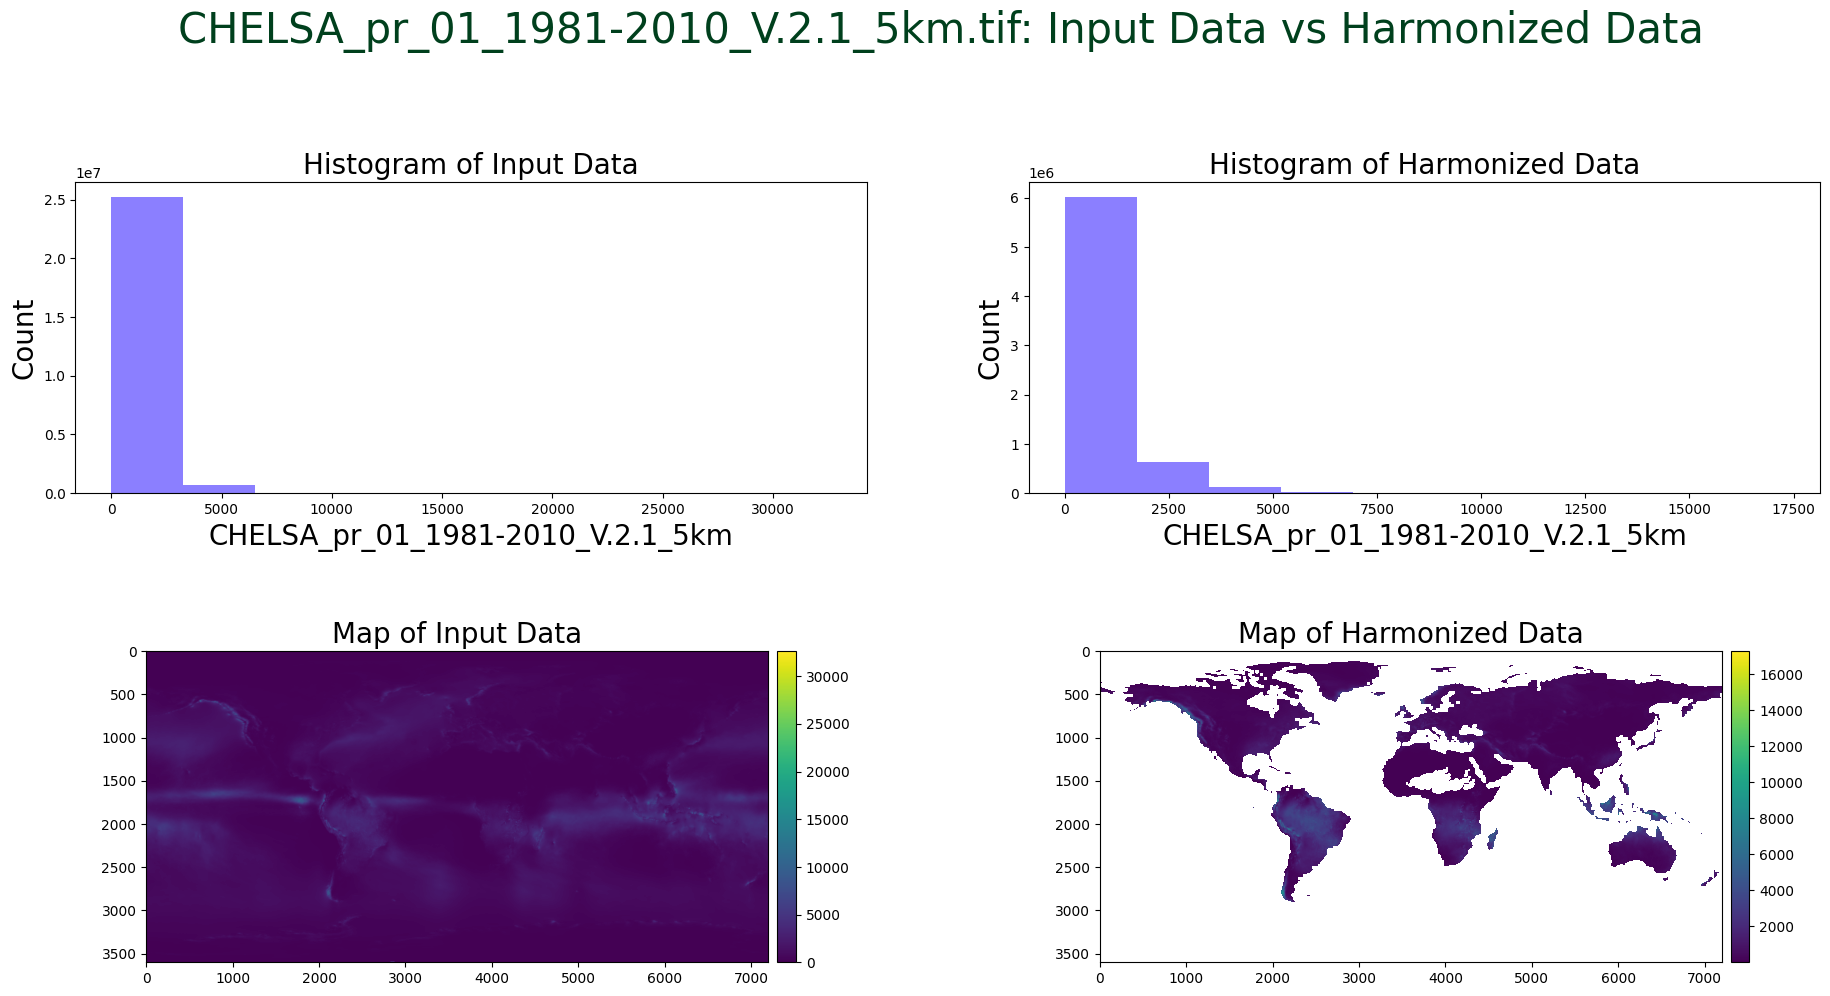

In [85]:
filename = "CHELSA_pr_01_1981-2010_V.2.1_5km.tif"

input_path = os.path.join("inputs/downloads", filename)
input_file = rxr.open_rasterio(input_path, masked=True)

harmonized_path = os.path.join("inputs/processed", f"harmonized_{filename}")
output_file = rxr.open_rasterio(harmonized_path, masked=True)
# Set the 0 values in the harmonized file to NaN to mask the oceans
output_file = output_file.where(output_file > 0)

# Plot the comparison graphics
fig = plt.figure(figsize=(20, 20))
fig.suptitle(f"{filename}: Input Data vs Harmonized Data", fontsize=30, color="#00401D")

ax1 = fig.add_subplot(421)
ax2 = fig.add_subplot(422)
ax3 = fig.add_subplot(423)
ax4 = fig.add_subplot(424)

input_file.plot.hist(ax=ax1, color="#1900ff", alpha=0.5)
output_file.plot.hist(ax=ax2, color="#1900ff", alpha=0.5)
output_file = output_file.squeeze()
input_file = input_file.squeeze()
map1 = ax3.imshow(input_file)
map2 = ax4.imshow(output_file)

ax1.set_title("Histogram of Input Data", fontsize=20)
ax1.set_xlabel(filename[:-4], fontsize=20)
ax1.set_ylabel("Count", fontsize=20)
ax1.tick_params(axis='both', which='both', labelsize=10)

ax2.set_title("Histogram of Harmonized Data", fontsize=20)
ax2.set_xlabel(filename[:-4], fontsize=20)
ax2.set_ylabel("Count", fontsize=20)
ax2.tick_params(axis='both', which='both', labelsize=10)

ax3.set_title("Map of Input Data", fontsize=20)
ax3.tick_params(axis='both', which='both', labelsize=10)
cb = ep.colorbar(map1)

ax4.set_title("Map of Harmonized Data", fontsize=20)
ax4.tick_params(axis='both', which='both', labelsize=10)
cb = ep.colorbar(map2)

fig.tight_layout(pad=5.0)
plt.show()

## Input Data (Open Data Cube)
The Open Data Cube ([ODC](https://www.opendatacube.org/)) consists of a set of Python libraries and PostgreSQL database to enable working with large scale geospatial raster data. You can view [example notebooks](https://github.com/ceos-seo/odc-colab) demonstrating usage of the Data Cube and explore [source code](https://github.com/ceos-seo/data_cube_utilities) for the ODC utilities.

In the code below, we will ingest 2 MODIS products from ODC and use them as covariates in our model. The MODIS products include:
1. Long-term averaged annual mean surface reflectances for MODIS bands 4 (NIR) and 7 (MIR) at 5 km resolution, derived using a stack of MOD09A1 images
2. Long-term averaged annual mean of the MODIS land surface temperature (daytime and nighttime) at 5 km resolution, derived using a stack of MOD11A2 images

In [8]:
notebook_name="SOC_FLUX_AFOLU"
dc = Datacube(app=notebook_name)

**View Open Data Cube products:**

In [9]:
dc.list_products()

,name,description,license,default_crs,default_resolution
name,,,,,
MOD09A1,MOD09A1,The MOD09A1 V6.1 product provides an estimate ...,None,"PROJCRS[""MODIS Sinusoidal"",BASEGEOGCRS[""WGS 84...","(-500, 500)"
MOD11A2,MOD11A2,,None,"PROJCRS[""MODIS Sinusoidal"",BASEGEOGCRS[""WGS 84...","(-1000, 1000)"


**View measurements in MOD09A1:**

In [10]:
dc.list_measurements().loc['MOD09A1']

,name,dtype,units,nodata,aliases,scale_factor,flags_definition,add_offset
measurement,,,,,,,,
sur_refl_b04,sur_refl_b04,int16,,-32768,"[surface_reflectance_for_band_4, sur_refl_b04,...",0.0001,NaN,NaN
sur_refl_b07,sur_refl_b07,int16,,-32768,"[surface_reflectance_for_band_7, sur_refl_b07,...",0.0001,NaN,NaN
QA,QA,uint32,,0,[surface_reflectance_500m_band_quality_control...,NaN,"{'modland_qa_bits': {'bits': [0, 1], 'values':...",NaN
SolarZenith,SolarZenith,int16,Degrees,-32768,"[modis_solar_zenith_angle, solarzenith]",0.0100,NaN,NaN
ViewZenith,ViewZenith,int16,Degrees,-32768,"[modis_view_zenith_angle, viewzenith]",0.0100,NaN,NaN
RelativeAzimuth,RelativeAzimuth,int16,Degrees,-32768,"[modis_relative_azimuth_angle, relativeazimuth]",0.0100,NaN,NaN
StateQA,StateQA,uint16,,0,"[surface_reflectance_500m_state_flags, stateqa]",NaN,"{'cloud_state': {'bits': [0, 1], 'values': {'0...",NaN
DayOfYear,DayOfYear,uint16,,0,"[julian_day_of_the_year_for_the_pixel, dayofyear]",NaN,NaN,NaN


**View measurements in MOD11A2:**

In [11]:
dc.list_measurements().loc['MOD11A2']

,name,dtype,units,nodata,aliases,scale_factor,flags_definition,add_offset
measurement,,,,,,,,
LST_Day_1km,LST_Day_1km,uint16,Kelvin,0,"[day_land_surface_temperature, lst_day_1km]",0.020,NaN,NaN
QC_Day,QC_Day,uint8,,0,"[daytime_lst_quality_indicators, qc_day]",NaN,"{'lst_error_flag': {'bits': [6, 7], 'values': ...",NaN
Day_view_time,Day_view_time,uint8,Hours,0,"[local_time_of_day_observation, day_view_time]",0.100,NaN,NaN
Day_view_angl,Day_view_angl,uint8,Degrees,0,"[view_zenith_angle_of_day_observation, day_vie...",NaN,NaN,-65.00
LST_Night_1km,LST_Night_1km,uint16,Kelvin,0,"[night_land_surface_temperature, lst_night_1km]",0.020,NaN,NaN
QC_Night,QC_Night,uint8,,0,"[nighttime_lst_quality_indicators, qc_night]",NaN,"{'lst_error_flag': {'bits': [6, 7], 'values': ...",NaN
Night_view_time,Night_view_time,uint8,Hours,0,"[local_time_of_night_observation, night_view_t...",0.100,NaN,NaN
Night_view_angl,Night_view_angl,uint8,Degrees,0,"[view_zenith_angle_of_night_observation, night...",NaN,NaN,-65.00
Emis_31,Emis_31,uint8,,0,"[band_31_emissivity, emis_31]",0.002,NaN,0.49


**Configure MOD09A1 data:**

In [12]:
product="MOD09A1"
latitude = (-90.0, 90.0)
longitude = (-180.0, 180.0)
time=('2018-01-01', '2022-12-31')
measurements=['sur_refl_b04', 'sur_refl_b07']
output_crs='EPSG:4326'

**Load MOD09A1 data:**

In [13]:
mod09 = dc.load(
        product=product,
        latitude=latitude,
        longitude=longitude,
        time=time,
        output_crs= output_crs,
        resolution=(0.05, 0.05),  # to convert to 5 km resolution
        measurements=measurements)

mod09

<xarray.Dataset>
Dimensions:       (time: 230, latitude: 3600, longitude: 7200)
Coordinates:
  * time          (time) datetime64[ns] 2018-01-01 2018-01-09 ... 2022-12-27
  * latitude      (latitude) float64 -89.97 -89.92 -89.88 ... 89.88 89.93 89.98
  * longitude     (longitude) float64 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
    spatial_ref   int32 4326
Data variables:
    sur_refl_b04  (time, latitude, longitude) int16 -32768 -32768 ... -32768
    sur_refl_b07  (time, latitude, longitude) int16 -32768 -32768 ... -32768
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

**Configure MOD11A2 data:**

In [14]:
product="MOD11A2"
latitude=(-90.0, 90.0)
longitude=(-180.0, 180.0)
time=('2018-01-01', '2022-12-31')
measurements=['LST_Day_1km', 'LST_Night_1km']
output_crs = 'EPSG:4326'

**Load MOD11A2 data:**

In [15]:
mod11 = dc.load(
        product=product,
        lat=latitude,
        lon=longitude,
        time=time,
        measurements= measurements,
        resolution=(0.05, 0.05),
        output_crs= output_crs
)
mod11

<xarray.Dataset>
Dimensions:        (time: 230, latitude: 3600, longitude: 7200)
Coordinates:
  * time           (time) datetime64[ns] 2018-01-01 2018-01-09 ... 2022-12-27
  * latitude       (latitude) float64 -89.97 -89.92 -89.88 ... 89.88 89.93 89.98
  * longitude      (longitude) float64 -180.0 -179.9 -179.9 ... 179.9 180.0
    spatial_ref    int32 4326
Data variables:
    LST_Day_1km    (time, latitude, longitude) uint16 0 0 0 0 0 0 ... 0 0 0 0 0
    LST_Night_1km  (time, latitude, longitude) uint16 0 0 0 0 0 0 ... 0 0 0 0 0
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

In [16]:
# Compute annual mean from 5 year data
mod09_clim = mod09.resample(time='AS').mean(dim='time').mean(dim='time')

mod09_clim

<xarray.Dataset>
Dimensions:       (latitude: 3600, longitude: 7200)
Coordinates:
  * latitude      (latitude) float64 -89.97 -89.92 -89.88 ... 89.88 89.93 89.98
  * longitude     (longitude) float64 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
    spatial_ref   int32 4326
Data variables:
    sur_refl_b04  (latitude, longitude) float64 -3.277e+04 ... -3.277e+04
    sur_refl_b07  (latitude, longitude) float64 -3.277e+04 ... -3.277e+04

In [17]:
# Compute annual mean from 5 year data
mod11_clim = mod11.resample(time='AS').mean(dim='time').mean(dim='time')
mod11_clim

<xarray.Dataset>
Dimensions:        (latitude: 3600, longitude: 7200)
Coordinates:
  * latitude       (latitude) float64 -89.97 -89.92 -89.88 ... 89.88 89.93 89.98
  * longitude      (longitude) float64 -180.0 -179.9 -179.9 ... 179.9 180.0
    spatial_ref    int32 4326
Data variables:
    LST_Day_1km    (latitude, longitude) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    LST_Night_1km  (latitude, longitude) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

## Combine ODC and Feature Data

**Combine MOD09A1 and MOD11A2 datasets:**
First, we combine the two climatology datasets we just created from MOD09A1 and MOD11A2 datasets using xarray's `merge` function. The resulting dataset is assigned a CRS.

In [25]:
combined = xr.merge([mod09_clim, mod11_clim], join='outer')
combined.rio.write_crs("epsg:4326", inplace=True)
combined

<xarray.Dataset>
Dimensions:        (latitude: 3600, longitude: 7200)
Coordinates:
  * latitude       (latitude) float64 -89.97 -89.92 -89.88 ... 89.88 89.93 89.98
  * longitude      (longitude) float64 -180.0 -179.9 -179.9 ... 179.9 180.0
    spatial_ref    int64 0
Data variables:
    sur_refl_b04   (latitude, longitude) float64 -3.277e+04 ... -3.277e+04
    sur_refl_b07   (latitude, longitude) float64 -3.277e+04 ... -3.277e+04
    LST_Day_1km    (latitude, longitude) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    LST_Night_1km  (latitude, longitude) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [28]:
# Output the data variables to the processed folder
combined["sur_refl_b04"].rio.to_raster('inputs/processed/harmonized_sur_refl_b04.tif')
combined["sur_refl_b07"].rio.to_raster('inputs/processed/harmonized_sur_refl_b07.tif')
combined["LST_Day_1km"].rio.to_raster('inputs/processed/harmonized_LST_Day_1km.tif')
combined["LST_Night_1km"].rio.to_raster('inputs/processed/harmonized_LST_Night_1km.tif')

**Combine all input data**  
We will use the [pyspatialml](https://stevenpawley.github.io/Pyspatialml/) library to run the machine learning model. This library takes a list of GDAL-supported raster datasets and 'stacks' them into a single Raster object. This process is performed in the code below.

In [44]:
# specify directory
directory = "inputs/processed"

# initialize raster_stack
raster_stack = None

# enumerate over all files in the directory
for i, filename in enumerate(os.listdir(directory)):
    # create full file path
    file_path = os.path.join(directory, filename)

    # Create a list of file path's to .tif files
    if file_path.endswith('.tif'):
        if raster_stack is None:
            raster_stack = [file_path]
        else:
            raster_stack.append(file_path)

# Stack the .tif files them into a single Raster object            
raster_stack = Raster(raster_stack)
raster_stack

Raster Object Containing 108 Layers
    attribute                                             values
0       names  [harmonized_CHELSA_tasmin_01_1981_2010_V_2_1_5...
1       files  [inputs/processed/harmonized_CHELSA_tasmin_01_...
2        rows                                               3600
3        cols                                               7200
4         res                                       (0.05, 0.05)
5  nodatavals  [None, None, None, None, None, None, None, Non...


## Create Training Datasets
We will use the Random Forest model provided by the Scikit-learn library. If you are new to this library, this [tutorial](https://scikit-learn.org/stable/tutorial/index.html) provides a great introduction to using it for machine learning tasks. We will now create the training dataset to be used in the machine learning model for producing global maps of Soil Organic Carbon, Soil Heterotropic Respiration, CEC and pH.

**Soil Organic Carbon:**

In [45]:
# Read in the shapefile containing field observations of SOC, and combine with the input datasets
paired_file = "inputs/processed/soc_paired.csv"
soc_training = gpd.read_file('inputs/training_data/WoSIS-OrganicCarbon.shp')

if not os.path.isfile(paired_file):
    soc_paired = raster_stack.extract_vector(soc_training)
    soc_paired["soc"] = soc_training["orgc_val_1"].values
    soc_paired = soc_paired.dropna()
    soc_paired.to_csv(paired_file, index=False)
else:
    soc_paired = pd.read_csv(paired_file)

# Drop any values beyond the 99th percentile as they are likely to be outliers
soc_paired = soc_paired[soc_paired["soc"] < np.percentile(soc_paired["soc"], 99)]

# Compute percentiles for the soc column, this column will be used to compute the probabilities 
# for a given SOC percentile
soc_paired["soc_percentile"] = pd.qcut(soc_paired["soc"], q=10)

In [46]:
soc_paired["soc_percentile"].describe()

count         476901
unique            10
top       (1.0, 2.0]
freq           57284
Name: soc_percentile, dtype: object

count    476901.000000
mean         19.355028
std          47.446634
min           0.000000
25%           2.300000
50%           6.000000
75%          15.000000
max         441.500000
Name: soc, dtype: float64


<AxesSubplot:>

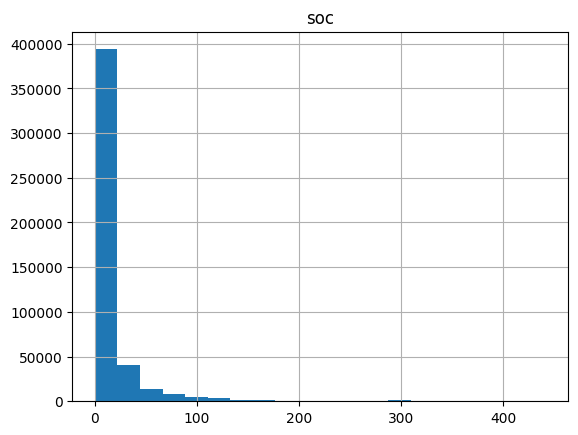

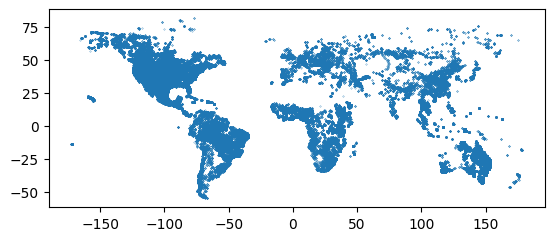

In [47]:
# Describe the distribution of values
print(soc_paired["soc"].describe())

# Plot histogram of values
soc_paired.hist(column="soc", bins=20)

# Plot map showing distribution of training data
soc_training.plot(markersize=0.05)

In [48]:
# We will use a randomly sampled 10% set of the total dataset to speed up the model training
# Comment out the two lines below to train the model on the full dataset
soc_paired = soc_paired.sample(frac=0.1)
print(len(soc_paired))

47690


**Soil Heterotrophic Respiration:** 

In [49]:
paired_file = "inputs/processed/shr_paired.csv"
shr_training = gpd.read_file('inputs/training_data/srdb-data-V5.shp')
    
if not os.path.isfile(paired_file):
    shr_paired = raster_stack.extract_vector(shr_training)
    shr_paired["shr"] = shr_training["Rs_annual"].values
    shr_paired = shr_paired.dropna()
    shr_paired.to_csv(paired_file, index=False)
else:
    shr_paired = pd.read_csv(paired_file)

# Drop any values beyond the 99th percentile as they are likely to be outliers
shr_paired = shr_paired[shr_paired["shr"] < np.percentile(shr_paired["shr"], 99)]

# Compute percentiles for the shr column, this column will be used to compute the probabilities 
# for a given shr percentile
shr_paired["shr_percentile"] = pd.qcut(shr_paired["shr"], q=10)

count    5506.000000
mean      811.316355
std       476.770625
min      -200.000000
25%       470.000000
50%       728.000000
75%      1062.000000
max      2910.000000
Name: shr, dtype: float64


<AxesSubplot:>

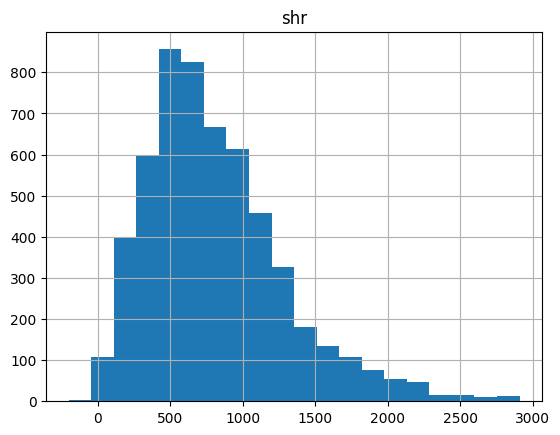

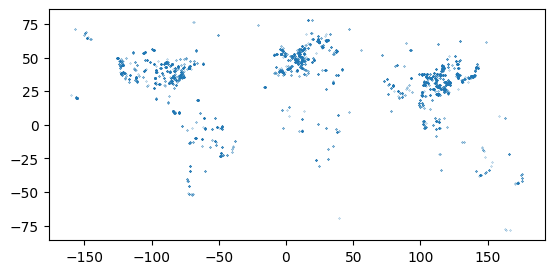

In [50]:
# Describe the distribution of values
print(shr_paired["shr"].describe())

# Plot histogram of values
shr_paired.hist(column="shr", bins=20)

# Plot map showing distribution of training data
shr_training.plot(markersize=0.05)

**Cation Exchange Capacity:**

In [51]:
paired_file = "inputs/processed/cec_paired.csv"
cec_training = gpd.read_file('inputs/training_data/wosis_latest_cecph7.shp')

if not os.path.isfile(paired_file):
    cec_paired = raster_stack.extract_vector(cec_training)
    cec_paired["cec"] = cec_training["cecph7_v_1"].values
    cec_paired = cec_paired.dropna()
    cec_paired.to_csv(paired_file, index=False)
else:
    cec_paired = pd.read_csv(paired_file)

# Drop any values beyond the 99th percentile as they are likely to be outliers
cec_paired = cec_paired[cec_paired["cec"] < np.percentile(cec_paired["cec"], 99)]

# Compute percentiles for the cec column, this column will be used to compute the probabilities 
# for a given cec percentile
cec_paired["cec_percentile"] = pd.qcut(cec_paired["cec"], q=10)

count    296991.000000
mean         16.771256
std          12.518255
min           0.100000
25%           7.500000
50%          13.900000
75%          22.800000
max          79.400000
Name: cec, dtype: float64


<AxesSubplot:>

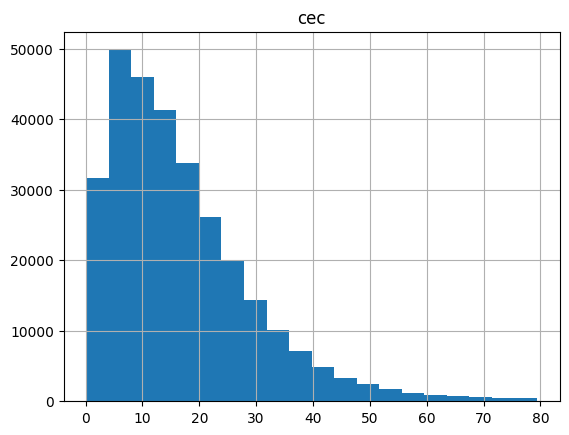

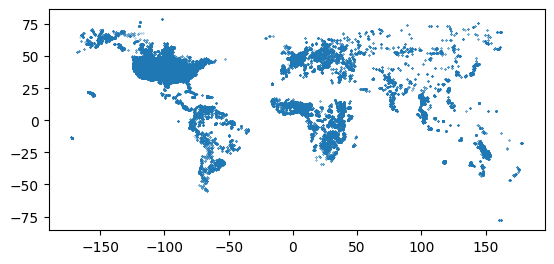

In [52]:
# Describe the distribution of values
print(cec_paired["cec"].describe())

# Plot histogram of values
cec_paired.hist(column="cec", bins=20)

# Plot map showing distribution of training data
cec_training.plot(markersize=0.05)

In [53]:
# We will use a randomly sampled 10% set of the total dataset to speed up the model training
# Comment out the two lines below to train the model on the full dataset
cec_paired = cec_paired.sample(frac=0.1)
print(len(cec_paired))

29699


**pH:**

In [54]:
paired_file = "inputs/processed/ph_paired.csv"
ph_training = gpd.read_file('inputs/training_data/wosis_latest_phaq.shp')
    
if not os.path.isfile(paired_file):
    ph_paired = raster_stack.extract_vector(ph_training)
    ph_paired["ph"] = ph_training["phaq_val_1"].values
    ph_paired = ph_paired.dropna()
    ph_paired.to_csv(paired_file, index=False)
else:
    ph_paired = pd.read_csv(paired_file)
    
# Drop any values beyond the 99th percentile as they are likely to be outliers
ph_paired = ph_paired[ph_paired["ph"] < np.percentile(ph_paired["ph"], 99)]

# Compute percentiles for the ph column, this column will be used to compute the probabilities 
# for a given ph percentile
ph_paired["ph_percentile"] = pd.qcut(ph_paired["ph"], q=10)

count    610498.000000
mean          6.327635
std           1.321865
min           1.500000
25%           5.200000
50%           6.200000
75%           7.500000
max           9.220000
Name: ph, dtype: float64


<AxesSubplot:>

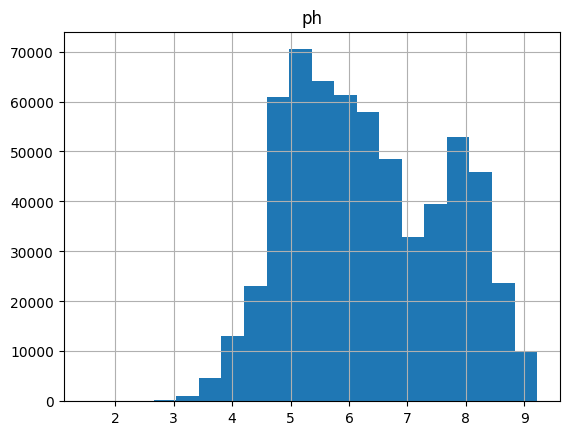

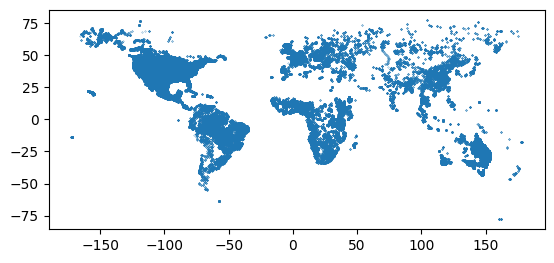

In [55]:
# Describe the distribution of values
print(ph_paired["ph"].describe())

# Plot histogram of values
ph_paired.hist(column="ph", bins=20)

# Plot map showing distribution of training data
ph_training.plot(markersize=0.05)

In [56]:
# We will use a randomly sampled 10% set of the total dataset to speed up the model training
# Comment out the two lines below to train the model on the full dataset
ph_paired = ph_paired.sample(frac=0.1)
print(len(ph_paired))

61050


## Soil Organic Carbon Model

The steps in using the Scikit-Learn estimator API are as follows:

1. Select a class of model by importing the estimator class from Scikit-Learn, here we use Random Forests
2. Select model hyperparameters by instantiating this class with desired values e.g. number of trees in the Random Forest
3. Create a feature matrix and target vector, see this [tutorial](https://jakevdp.github.io/PythonDataScienceHandbook/05.02-introducing-scikit-learn.html) for an in-depth explanation
4. Fit the model to your data by calling the fit() method of the model instance
5. Apply the model to new data by using the predict() method

We follow these 5 steps in sequence below. Additionally, we use the pipeline functionality in Scikit-learn to standardize features by removing the mean and scaling to unit variance.

**Create model:**

In [97]:
model = RandomForestRegressor(n_jobs=-1)
pipeline = Pipeline(
    [('scaling', StandardScaler()),
     ('regressor', RandomForestRegressor())]
)

**Set independent and dependent variables:**

In [98]:
X = soc_paired.drop(columns=["soc", "soc_percentile", "geometry"]).values
y = soc_paired["soc"].values

**Fit model:**

In [99]:
pipeline.fit(X, y)

Pipeline(steps=[('scaling', StandardScaler()),
                ('regressor', RandomForestRegressor())])

In [101]:
from sklearn.model_selection import cross_validate
scores = cross_validate(
    estimator=pipeline,
    X=X,
    y=y,
    scoring=["root_mean_squared_error", "r2"],
    cv=5,
    n_jobs=-1,
)
print(scores)

ValueError: 'root_mean_squared_error' is not a valid scoring value. Use sklearn.metrics.get_scorer_names() to get valid options.

**Plot predictions:**

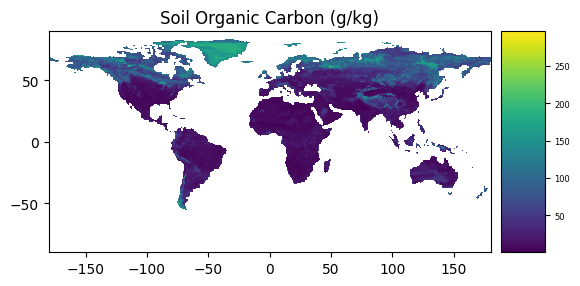

In [60]:
result = raster_stack.predict(estimator=pipeline, dtype='float32') # predict based on raster values
ax = result.plot()
ax.set_title("Soil Organic Carbon (g/kg)")
plt.show()

**Feature importance:**

The importance of a feature in a Random Forest model refers to how often a given feature is used in each tree of the forest. It is computed as the (normalized) total reduction of the criterion brought by that feature (https://inria.github.io/scikit-learn-mooc/index.html)

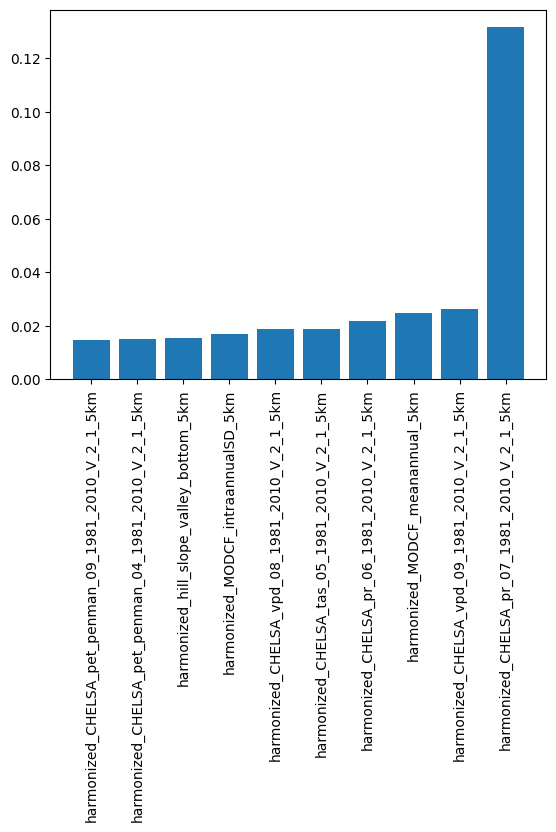

In [61]:
col_names = soc_paired.drop(columns=["soc", "soc_percentile", "geometry"]).columns
imp = pipeline.steps[1][1].feature_importances_

# Obtain the names and importance scores of the top 10 inputs
N = 10

# sorted array
sorted_array = imp[np.argsort(imp)]

# Find N largest value
top_vals = sorted_array[-N:]

# Find column names corresponding to these N largest values
top_col_names = col_names[imp.argsort()[-N:][::-1]]

fig, ax = plt.subplots()
ax.bar(top_col_names, top_vals)
plt.xticks(rotation=90)
plt.show()

**Save output:**

In [62]:
final = result.write(file_path="soc_output.tif")

**Probability of a given SOC percentile:**  
We computed deciles from the `soc` column and stored them in the `soc_percentile` column. We estimate the probability of each pixel getting results in a given decile using the `predict_proba` function from pyspatialml. In the plots below `prob_0` is a map showing the probability of getting `soc` values in the first decile for each pixel.

In [ ]:
model = RandomForestClassifier(n_jobs=-1)
pipeline = Pipeline(
    [('scaling', StandardScaler()),
     ('regressor', RandomForestClassifier())]
)

X = soc_paired.drop(columns=["soc", "soc_percentile", "geometry"]).values
y = soc_paired["soc_percentile"].cat.codes

pipeline.fit(X, y)

# The predict_proba method is used to output class probabilities as a multi-band raster
result_probs = raster_stack.predict_proba(estimator=pipeline)
result_probs.plot()
plt.show()

## Soil Heterotrophic Respiration Model

**Create model:**

In [92]:
model = RandomForestRegressor(n_jobs=-1)
pipeline = Pipeline(
    [('scaling', StandardScaler()),
     ('regressor', RandomForestRegressor())]
)

**Set independent and dependent variables:**

In [93]:
X = shr_paired.drop(columns=["shr", "shr_percentile", "geometry"]).values
y = shr_paired["shr"].values

**Fit model:**

In [94]:
pipeline.fit(X, y)

Pipeline(steps=[('scaling', StandardScaler()),
                ('regressor', RandomForestRegressor())])

In [96]:
from sklearn.model_selection import cross_validate
scores = cross_validate(
    estimator=pipeline,
    X=X,
    y=y,
    scoring="r2",
    cv=3,
    n_jobs=-1,
)
print(scores)


{'fit_time': array([11.12164736, 12.37764311, 10.86655521]), 'score_time': array([0.03191042, 0.03284645, 0.03124332]), 'test_score': array([0.19708665, 0.13835008, 0.04897056])}


**Plot predictions:**

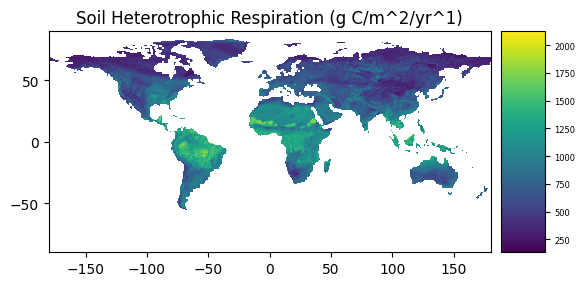

In [67]:
result = raster_stack.predict(estimator=pipeline) # predict based on raster values
ax = result.plot()
ax.set_title("Soil Heterotrophic Respiration (g C/m^2/yr^1)")
plt.show()

**Feature importances:**

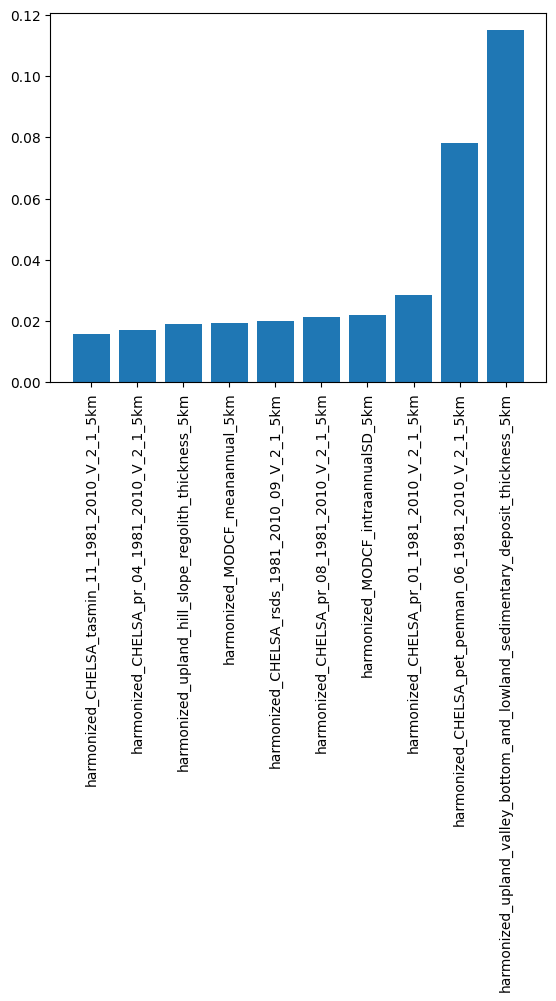

In [68]:
col_names = shr_paired.drop(columns=["shr", "shr_percentile", "geometry"]).columns
imp = pipeline.steps[1][1].feature_importances_

# Obtain the names and importance scores of the top 10 inputs
N = 10

# sorted array
sorted_array = imp[np.argsort(imp)]

# Find N largest value
top_vals = sorted_array[-N:]

# Find column names corresponding to these N largest values
top_col_names = col_names[imp.argsort()[-N:][::-1]]

fig, ax = plt.subplots()
ax.bar(top_col_names, top_vals)
plt.xticks(rotation=90)
plt.show()

**Save output:**

In [69]:
final = result.write(file_path="shr_output.tif")

**Probability of a given SHR percentile:**  
We computed deciles from the `shr` column and stored them in the `shr_percentile` column. We estimate the probability of each pixel getting results in a given decile using the `predict_proba` function from pyspatialml. In the plots below `prob_0` is a map showing the probability of getting `shr` values in the first decile for each pixel.

/home/datacube/.local/lib/python3.10/site-packages/matplotlib/image.py:487: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)


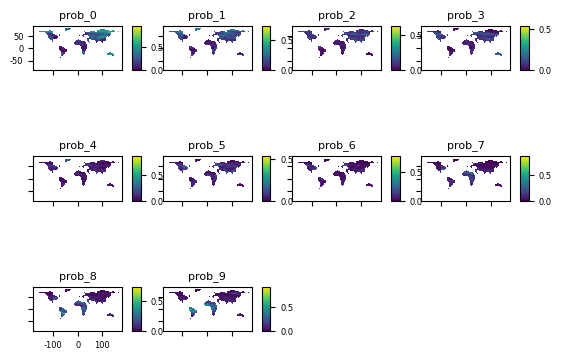

In [86]:
model = RandomForestClassifier(n_jobs=-1)
pipeline = Pipeline(
    [('scaling', StandardScaler()),
     ('regressor', RandomForestClassifier())]
)

X = shr_paired.drop(columns=["shr", "shr_percentile", "geometry"]).values
y = shr_paired["shr_percentile"].cat.codes

pipeline.fit(X, y)

# The predict_proba method is used to output class probabilities as a multi-band raster
result_probs = raster_stack.predict_proba(estimator=pipeline)
result_probs.plot()
plt.show()

## Cation Exchange Capacity Model

**Create model:**

In [70]:
model = RandomForestRegressor(n_jobs=-1)
pipeline = Pipeline(
    [('scaling', StandardScaler()),
     ('regressor', RandomForestRegressor())]
)    

**Set independent and dependent variables:**

In [71]:
X = cec_paired.drop(columns=["cec", "cec_percentile", "geometry"]).values
y = cec_paired["cec"].values

**Fit model:**

In [72]:
pipeline.fit(X, y);

**Plot predictions:**

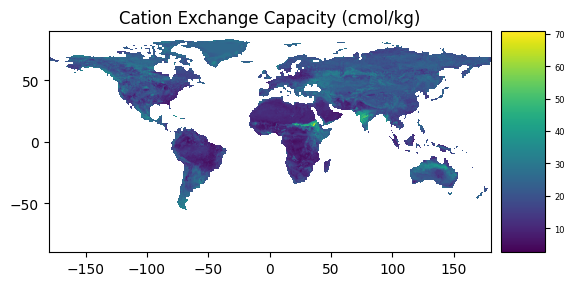

In [73]:
result = raster_stack.predict(estimator=pipeline, dtype='float32') # predict based on raster values
ax = result.plot()
ax.set_title("Cation Exchange Capacity (cmol/kg)")
plt.show()

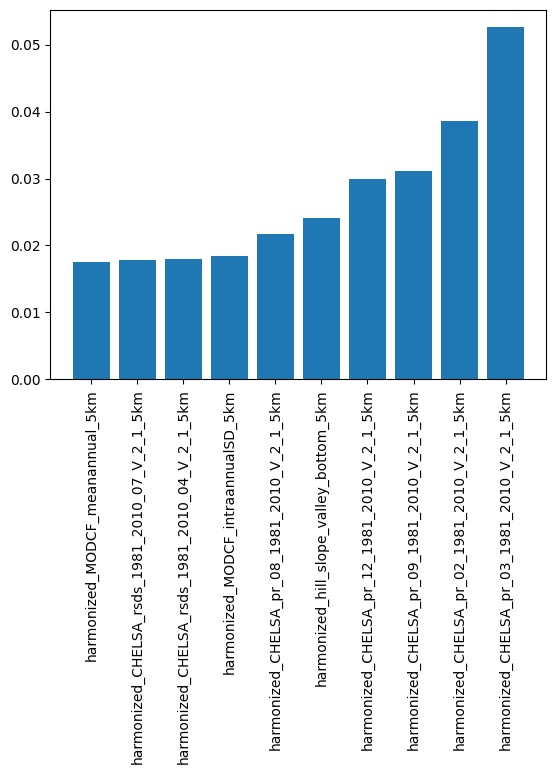

In [74]:
col_names = cec_paired.drop(columns=["cec", "cec_percentile", "geometry"]).columns
imp = pipeline.steps[1][1].feature_importances_

# Obtain the names and importance scores of the top 10 inputs
N = 10

# sorted array
sorted_array = imp[np.argsort(imp)]

# Find N largest value
top_vals = sorted_array[-N:]

# Find column names corresponding to these N largest values
top_col_names = col_names[imp.argsort()[-N:][::-1]]

fig, ax = plt.subplots()
ax.bar(top_col_names, top_vals)
plt.xticks(rotation=90)
plt.show()

**Save output:**

In [75]:
final = result.write(file_path="cec_output.tif")

**Probability of a given CEC percentile:**  
We computed deciles from the `cec` column and stored them in the `cec_percentile` column. We estimate the probability of each pixel getting results in a given decile using the `predict_proba` function from pyspatialml. In the plots below `prob_0` is a map showing the probability of getting `cec` values in the first decile for each pixel.

/home/datacube/.local/lib/python3.10/site-packages/matplotlib/image.py:487: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)


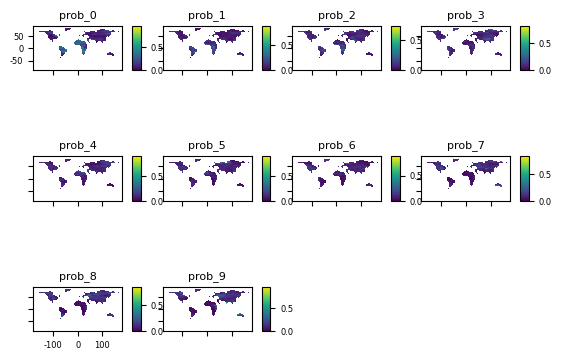

In [89]:
model = RandomForestClassifier(n_jobs=-1)
pipeline = Pipeline(
    [('scaling', StandardScaler()),
     ('regressor', RandomForestClassifier())]
)

X = cec_paired.drop(columns=["cec", "cec_percentile", "geometry"]).values
y = cec_paired["cec_percentile"].cat.codes

pipeline.fit(X, y)

# The predict_proba method is used to output class probabilities as a multi-band raster
result_probs = raster_stack.predict_proba(estimator=pipeline)
result_probs.plot()
plt.show()

## pH Model

**Create model:**

In [76]:
model = RandomForestRegressor(n_jobs=-1)
pipeline = Pipeline(
    [('scaling', StandardScaler()),
     ('regressor', RandomForestRegressor())]
)

**Set independent and dependent variables:**

In [77]:
X = ph_paired.drop(columns=["ph", "ph_percentile", "geometry"]).values
y = ph_paired["ph"].values

**Fit model:**

In [78]:
pipeline.fit(X, y);

**Plot predictions:**

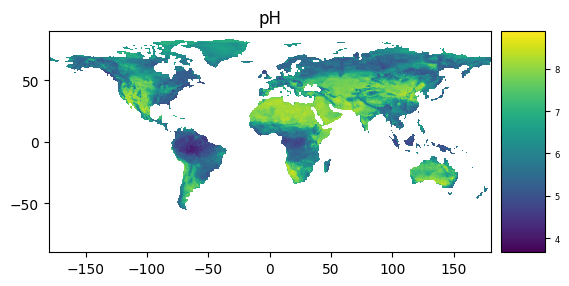

In [79]:
result = raster_stack.predict(estimator=pipeline, dtype='float32') # predict based on raster values
ax = result.plot()
ax.set_title("pH")
plt.show()

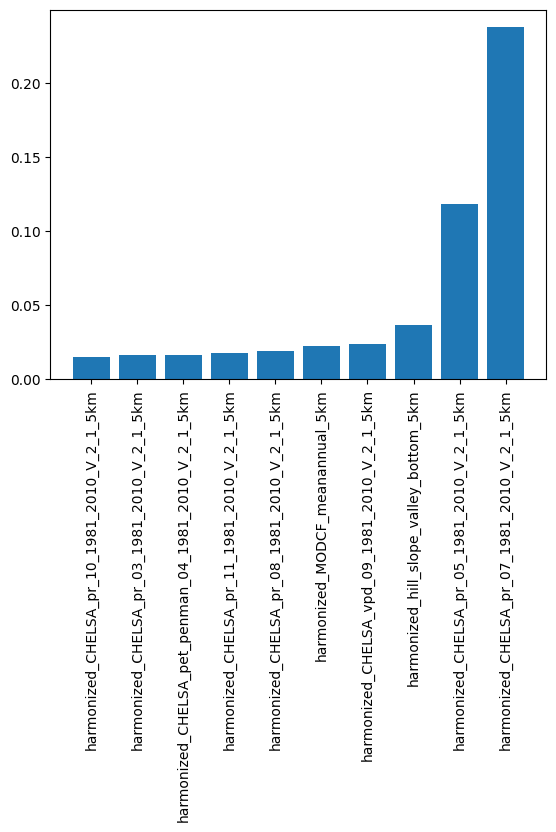

In [80]:
col_names = ph_paired.drop(columns=["ph", "ph_percentile", "geometry"]).columns
imp = pipeline.steps[1][1].feature_importances_

# Obtain the names and importance scores of the top 10 inputs
N = 10

# sorted array
sorted_array = imp[np.argsort(imp)]

# Find N largest value
top_vals = sorted_array[-N:]

# Find column names corresponding to these N largest values
top_col_names = col_names[imp.argsort()[-N:][::-1]]

fig, ax = plt.subplots()
ax.bar(top_col_names, top_vals)
plt.xticks(rotation=90)
plt.show()

**Save output:**

In [81]:
final = result.write(file_path="ph_output.tif")

**Probability of a given pH percentile:**  
We computed deciles from the `ph` column and stored them in the `ph_percentile` column. We estimate the probability of each pixel getting results in a given decile using the `predict_proba` function from pyspatialml. In the plots below `prob_0` is a map showing the probability of getting `ph` values in the first decile for each pixel.

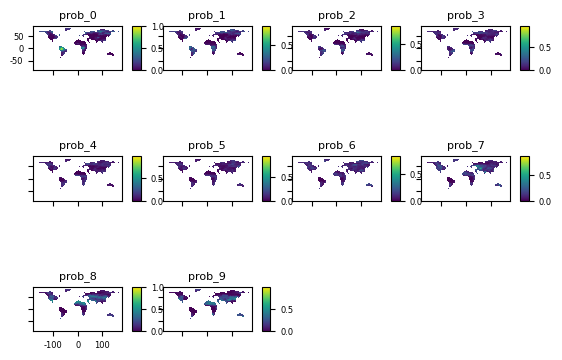

In [88]:
model = RandomForestClassifier(n_jobs=-1)
pipeline = Pipeline(
    [('scaling', StandardScaler()),
     ('regressor', RandomForestClassifier())]
)

X = ph_paired.drop(columns=["ph", "ph_percentile", "geometry"]).values
y = ph_paired["ph_percentile"].cat.codes

pipeline.fit(X, y)

# The predict_proba method is used to output class probabilities as a multi-band raster
result_probs = raster_stack.predict_proba(estimator=pipeline)
result_probs.plot()
plt.show()